<a href="https://colab.research.google.com/github/LEFT-BEE/small_project/blob/main/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten,  MaxPooling2D, Dense, Activation,Conv2D,LeakyReLU
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hanseungjin","key":"846d5bf6dc07302ec1dce37a20a41933"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tongpython/cat-and-dog

 96% 210M/218M [00:04<00:00, 52.8MB/s]
100% 218M/218M [00:04<00:00, 52.2MB/s]


In [4]:
import zipfile 

with zipfile.ZipFile('/content/cat-and-dog.zip', 'r') as existing_zip:
    existing_zip.extractall('/content')

In [5]:
ROW = 64
COL = 64
CHANNEL = 3
train_dir = "/content/training_set/training_set/"
test_dir = "/content/test_set/test_set/"
train_cat=[train_dir +"cats/"+ i for i in os.listdir("/content/training_set/training_set/cats/")]
train_dog =[train_dir +"dogs/" +i for i in os.listdir("/content/training_set/training_set/dogs/")]
test_cat = [test_dir +"cats/" +i for i in os.listdir("/content/test_set/test_set/cats/")]
test_dog = [train_dir +"dogs/" +i for i in os.listdir("/content/test_set/test_set/dogs/")]

In [41]:
train_cat_dog = train_cat[:1000] + train_dog[:1000]
random.shuffle(train_cat_dog)

test_cat_dog = test_cat[:125] + test_dog[:125]
random.shuffle(test_cat_dog)


In [7]:
def read_image(file_path):

    img = cv2.imread(file_path)
    return cv2.resize(img , (ROW , COL))



def prep_data(images):
  count = len(images)
  data = np.ndarray((count , ROW, COL ,CHANNEL) , dtype = np.float32)

  for i, image_file in enumerate(images):
    try:
      if image_file =="/content/training_set/training_set/dogs/_DS_Store" or image_file == "/content/training_set/training_set/cats/_DS_Store":
        continue;
      image = read_image(image_file)
      data[i] = image
      if i%250 == 0: print('precessed {} of {}'.format(i,count))
    except:
      continue

  return data

In [42]:
train = prep_data(train_cat_dog)
test = prep_data(test_cat_dog)
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))


precessed 0 of 2000
precessed 250 of 2000
precessed 500 of 2000
precessed 750 of 2000
precessed 1000 of 2000
precessed 1250 of 2000
precessed 1500 of 2000
precessed 1750 of 2000
precessed 0 of 250
Train shape: (2000, 64, 64, 3)
Test shape: (250, 64, 64, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


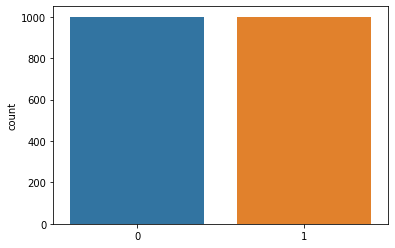

In [43]:
labels = []
for i in train_cat_dog:
  if 'dog' in i:
    labels.append(1)
  else:
    labels.append(0)

sns.countplot(labels)

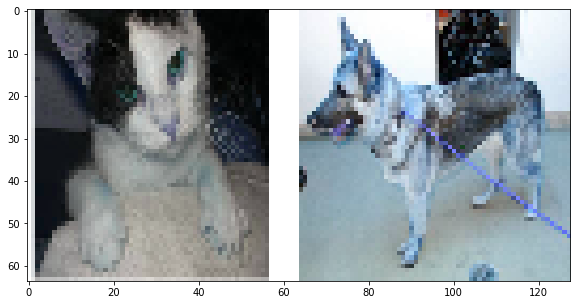

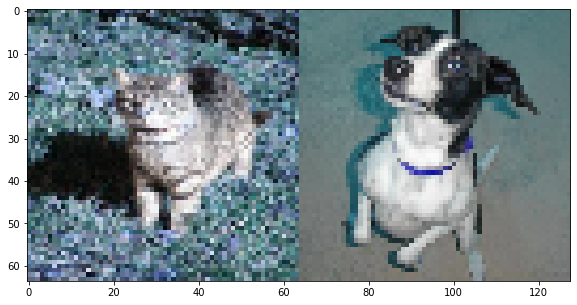

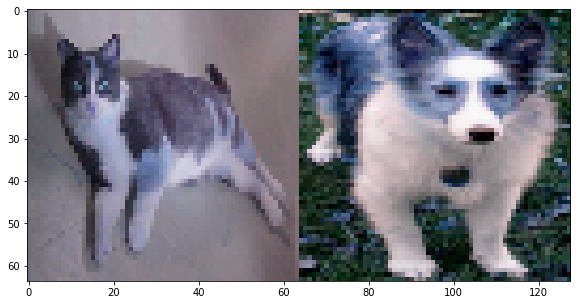

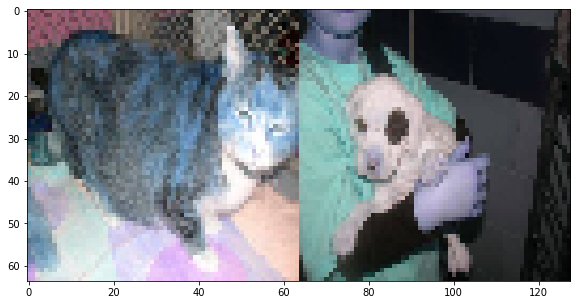

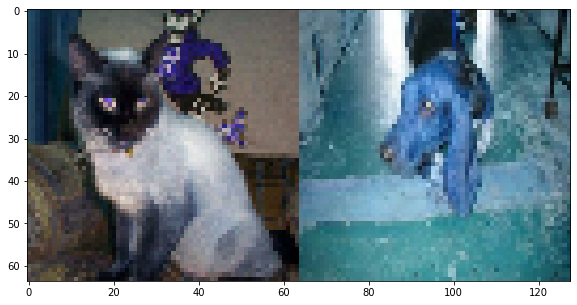

In [44]:
def show_cats_dogs(idx):
  cat =read_image(train_cat[idx])
  dog = read_image(train_dog[idx])
  pair = np.concatenate((cat , dog) ,axis = 1)
  plt.figure(figsize = (10,5))
  plt.imshow(pair)
  plt.show()

for idx in range(0,5):
  show_cats_dogs(idx)



In [45]:
def model():

  dis = Sequential()

  dis.add(
        Conv2D(128, (5, 5),
               padding='same',
               input_shape=(ROW, COL ,3))
  )
  dis.add(LeakyReLU(alpha = 0.2))
  dis.add(MaxPooling2D(pool_size = (2,2)))

  dis.add(Conv2D(filters = 256 , kernel_size =(3,3) , strides=(1 ,1) , padding = 'same' ))#30 30 256
  dis.add(LeakyReLU(alpha = 0.2))


  dis.add(Conv2D(filters = 512 , kernel_size =(3,3) , strides=(1 ,1) , padding = 'same' ))#13 13 512
  dis.add(LeakyReLU(alpha = 0.2))


  dis.add(Flatten())

  dis.add(Dense(1024))
  dis.add(LeakyReLU(alpha = 0.2))

  dis.add(Dense(1))
  dis.add(Activation('sigmoid'))


  return dis

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto') 
optimizers = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
loss = 'binary_crossentropy'
nb_epoch =10
batch_size = 100

model = model()
model.compile(loss = "binary_crossentropy" , optimizer=optimizers , metrics = ['accuracy'])

In [47]:
class LossHistory(Callback):
  def on_train_begin(self ,logs = {}):
    self.losses = []
    self.val_losses = []

  def on_epoch_end(self, batch , logs = {}):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

In [48]:
val_train = train[1500:2000]
val_label = labels[1500:2000]

train = train[0:1500]
labels = labels[0:1500]

In [49]:
train_re = np.array(train)
label_re = np.array(labels)
val_train_new = np.array(val_train)
val_label_new = np.array(val_label)

In [50]:
test_img  = np.array(test)

In [51]:
def run_catdog():

    history = LossHistory()
    model.fit(train_re, label_re,  epochs=nb_epoch, batch_size = batch_size,
              validation_data = (val_train_new , val_label_new), verbose=0, shuffle=True, callbacks=[history, early_stopping])
  
    predictions = model.predict(test_img, verbose=0)
    return predictions, history

In [52]:
predictions, history = run_catdog()

ResourceExhaustedError: ignored

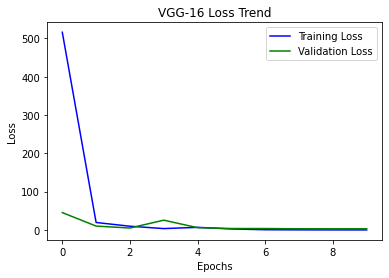

In [18]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 53.01% sure this is a Cat


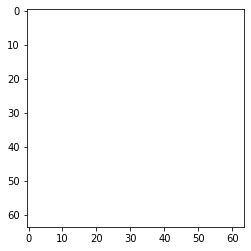

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 95.76% sure this is a Dog


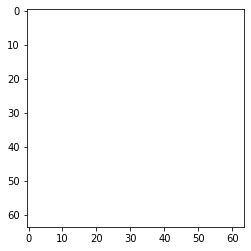

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 53.01% sure this is a Cat


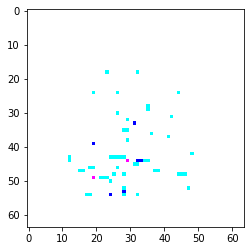

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 53.01% sure this is a Cat


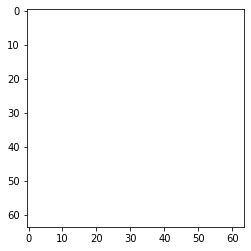

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 100.00% sure this is a Cat


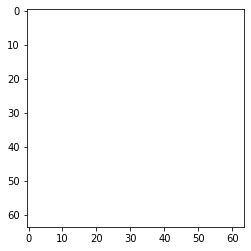

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 53.01% sure this is a Cat


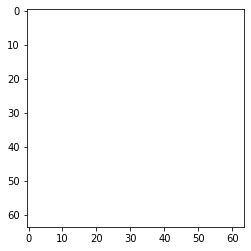

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 100.00% sure this is a Dog


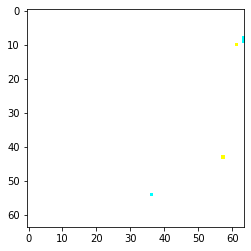

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 53.01% sure this is a Cat


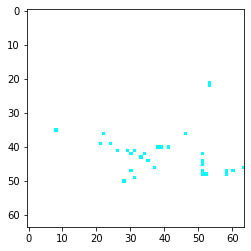

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 76.73% sure this is a Cat


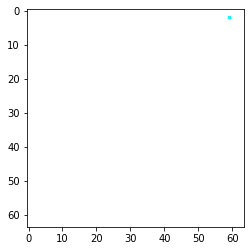

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 53.01% sure this is a Cat


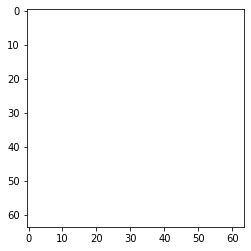

In [57]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(train[i])
    plt.show()

In [59]:
print(labels)

[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 